In [1]:
### Instalacion

In [2]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2
import torch; torch._dynamo.config.recompile_limit = 64;

In [3]:
%%capture
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [4]:
# Imports

In [5]:
import unsloth
from unsloth import FastModel
from unsloth import FastVisionModel
import torch

from google.colab import drive
from google.colab import userdata
from huggingface_hub import login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from functools import partial
from datetime import datetime

from unsloth import FastLanguageModel
from unsloth.chat_templates import standardize_data_formats
from unsloth.chat_templates import get_chat_template
from transformers import TrainingArguments
from datasets import Dataset
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from unsloth.chat_templates import train_on_responses_only
from unsloth.trainer import UnslothVisionDataCollator

from datasets import load_from_disk, DatasetDict
from sklearn.model_selection import train_test_split
import pickle


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
### Cargar dataset

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

In [9]:
ruta = '/content/drive/MyDrive/Colab Notebooks/DatasetV2_Finetune/DatasetV2_Finetune.csv'
df = pd.read_csv(ruta, encoding='utf-8')

# Mostrar las primeras filas
print(df.head())

                                         url  \
0                              carscoops.com   
1                                 zappos.com   
2                                  bosch.com   
3                http://hdgw78282.weebly.com   
4  http://mdimranhossaing.github.io/facebook   

                                        html_content  \
0                       0001_carscoops.com/page.html   
1                          0002_zappos.com/page.html   
2                           0003_bosch.com/page.html   
3                0004_hdgw78282.weebly.com/page.html   
4  0005_mdimranhossaing.github.io_facebook/page.html   

                                          screenshot  label  
0                  0001_carscoops.com/screenshot.png      0  
1                     0002_zappos.com/screenshot.png      0  
2                      0003_bosch.com/screenshot.png      0  
3           0004_hdgw78282.weebly.com/screenshot.png      1  
4  0005_mdimranhossaing.github.io_facebook/screen...      1  


In [10]:
# Eliminar filas con valores faltantes
df.dropna(inplace=True)

# Información general del dataset combinado
print(df.info())

# Estadísticas descriptivas
print(df.describe())

# Verificar valores faltantes
print(df.isnull().sum())

# Verificar la distribución de etiquetas
if 'label' in df.columns:
    print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           5000 non-null   object
 1   html_content  5000 non-null   object
 2   screenshot    5000 non-null   object
 3   label         5000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 156.4+ KB
None
            label
count  5000.00000
mean      0.50000
std       0.50005
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
url             0
html_content    0
screenshot      0
label           0
dtype: int64
label
0    2500
1    2500
Name: count, dtype: int64


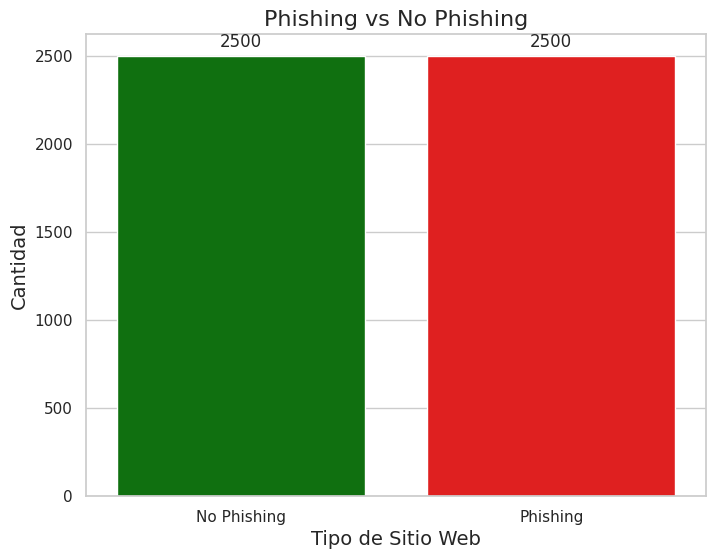

In [11]:
# Crear un diccionario para mapear las etiquetas
label_map = {0: 'No Phishing', 1: 'Phishing'}

# Crear una nueva columna con las etiquetas mapeadas
df['label_name'] = df['label'].map(label_map)

# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label_name', data=df, hue='label_name', palette={'No Phishing': 'green', 'Phishing': 'red'}, legend=False)

# Agregar título y etiquetas
plt.title('Phishing vs No Phishing', fontsize=16)
plt.xlabel('Tipo de Sitio Web', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)

# Agregar los valores en las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

# Mostrar el gráfico
plt.show()

In [12]:
### Preparar finetuning

In [13]:
model, processor = FastVisionModel.from_pretrained(
    "unsloth/gemma-3n-E4B-it",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.10.7: Fast Gemma3N patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

In [14]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [15]:
#  processor = get_chat_template(
#      processor,
#      "gemma-3n"
#  )

In [16]:
def _cargar_datos_fila(row, ruta_base):
    html_path = os.path.join(ruta_base, row['html_content'])
    screenshot_path = os.path.join(ruta_base, row['screenshot'])
    with open(html_path, 'r', encoding='utf-8') as file:
        html_content = file.read()[:5000]
    try:
        screenshot = Image.open(screenshot_path).convert('RGB').resize((512, 512))
    except Exception as e:
        print(f"Error img {row['url']}: {e}")
        screenshot = Image.new('RGB', (512, 512), color='black')
    return html_content, screenshot

In [17]:
ruta_base_archivos = '/content/drive/MyDrive/Colab Notebooks/DatasetV2_Finetune'
ruta_base_archivos = os.path.join(ruta_base_archivos, '')
ruta_csv = '/content/drive/MyDrive/Colab Notebooks/DatasetV2_Finetune/DatasetV2_Finetune.csv'

df = pd.read_csv(ruta_csv, encoding='utf-8')
df.dropna(inplace=True)

# Test con subconjunto (10 rows – rápido)
#df = df.head(120)  # O df.sample(10, random_state=42) para aleatorio


df[['html_content', 'screenshot']] = df.apply(
    lambda row: pd.Series(_cargar_datos_fila(row, ruta_base_archivos)), axis=1
)

print("Multimodal cargado. Ejemplo HTML len:", len(df.iloc[0]['html_content']))
print("Ejemplo screenshot size:", df.iloc[0]['screenshot'].size if df.iloc[0]['screenshot'] else "None")
#print(df[0])

Multimodal cargado. Ejemplo HTML len: 5000
Ejemplo screenshot size: (512, 512)


In [18]:
print(f"DF cargado desde pickle: {len(df)} samples")
print("Ejemplo HTML len:", len(df.iloc[0]['html_content']))
print("Ejemplo screenshot size:", df.iloc[0]['screenshot'].size)
print("Ejemplo HTML:", df.iloc[0]['html_content'])
print("Ejemplo screenshot:", df.iloc[0]['screenshot'])

DF cargado desde pickle: 5000 samples
Ejemplo HTML len: 5000
Ejemplo screenshot size: (512, 512)
Ejemplo HTML: <!DOCTYPE html><html lang="en"><head><link href="https://fonts.googleapis.com/css?family=Archivo:400,500|Arimo:400,500|Bitter:400,500|EB+Garamond:400,500|Lato|Libre+Baskervill|Libre+Franklin:400,500|Lora:400,500|Google+Sans:regular,medium:400,500|Material+Icons|Google+Symbols|Merriweather|Montserrat:400,500|Mukta:400,500|Muli:400,500|Nunito:400,500|Open+Sans:400,500,600|Open+Sans+Condensed:400,600|Oswald:500|Playfair+Display:400,500|Poppins:400,500|Raleway:400,500|Roboto:400,500|Roboto+Condensed:400,500|Roboto+Slab:400,500|Slabo+27px|Source+Sans+Pro|Ubuntu:400,500|Volkhov&amp;display=swap" rel="stylesheet">
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>
        Carscoops    </title>

    <link rel="preconnect" href="https://fonts.googleapis.com">
    <li

In [19]:
def convert_to_conversation(row):  # Input: row (dict de df)
    label_val = row['label']
    label = "Phishing" if label_val == 1 or label_val == "phishing" else "Legitimate"

    instruction = """
    Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive a URL, the HTML of the website and a screenshot.
    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name
    """

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"{instruction}\nURL: {row['url']}\nHTML extract: {row['html_content'][:5000]}"},
                {"type": "image", "image": row['screenshot']},
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": label}],
        },
    ]
    return {"messages": conversation}  # Dict con "messages" como lista

In [20]:
converted_dataset = [convert_to_conversation(row) for _, row in df.iterrows()]
print(f"Lista completa: {len(converted_dataset)} samples")


Lista completa: 5000 samples


In [21]:
print(converted_dataset[119])

{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': '\n    Act as a professional cybersecurity specialist reviewing websites to determine if they are phishing or not. You will receive a URL, the HTML of the website and a screenshot.\n    Based on that, you have to classify the website as "Phishing" or "Legitimate". Just respond with the class name\n    \nURL: abc13.com\nHTML extract: <!DOCTYPE html><html lang="en" data-react-helmet="lang"><head><script async="" src="https://cdn-gl.imrworldwide.com/conf/PE1E8BB0E-5D9F-44FA-A0E2-E4A38939FBE6.js#name=nlsnInstance1&amp;ns=NOLBUNDLE"></script><script src="https://js-agent.newrelic.com/nr-spa-1216.min.js"></script><script type="text/javascript" src="https://js.appboycdn.com/web-sdk/5.6/braze.min.js" async=""></script><script src="//sb.scorecardresearch.com/cs/3000032/beacon.js"></script><script src="https://secure.espn.com/js/dcf/tags/vision/latest/vision-media.js"></script><script type="text/javascript" async="" src="https:/

In [22]:
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,  # ¡Lista directa, como original – sin Dataset!
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor, max_seq_length=8192),
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,

        gradient_checkpointing_kwargs={"use_reentrant": False},
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        #max_steps = 60,
        num_train_epochs = 2,
        learning_rate=2e-4,
        logging_steps=1,
        save_strategy="steps",
        optim="adamw_torch_fused",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir="outputs",
        report_to="none",

        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length=8192,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [23]:
trainer_stats = trainer.train()
print(f"✅ Training stats: {trainer_stats}")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,000 | Num Epochs = 2 | Total steps = 2,500
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 76,840,960 of 7,926,819,152 (0.97% trained)


Step,Training Loss
1,6.955300
2,7.124700
3,5.314700
4,3.174300
5,2.652000
6,2.690600
7,3.855900
8,2.385900
9,2.293700
10,2.424300


Step,Training Loss
1,6.955300
2,7.124700
3,5.314700
4,3.174300
5,2.652000
6,2.690600
7,3.855900
8,2.385900
9,2.293700
10,2.424300


✅ Training stats: TrainOutput(global_step=2500, training_loss=0.7891091937661171, metrics={'train_runtime': 14484.9718, 'train_samples_per_second': 0.69, 'train_steps_per_second': 0.173, 'total_flos': 6.731470687648253e+17, 'train_loss': 0.7891091937661171, 'epoch': 2.0})


In [24]:
# Guarda LoRA en Drive (persistente)
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/gemma3n-it-phishing-lora")
processor.save_pretrained("/content/drive/MyDrive/Colab Notebooks/gemma3n-it-phishing-lora")
print("✅ Modelo guardado en Drive. Carpeta: gemma3n-it-phishing-lora")

✅ Modelo guardado en Drive. Carpeta: gemma3n-it-phishing-lora
